In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import torch
import torch.autograd
from torch.optim import AdamW, SGD, Adam
import torch.nn

import random
import stim
import stim_model
import cpn_model
import utils


# A 'Thing' is the thing we are stimulating. It is basically
# a single variable diffeq-goverened system that merely dampens
# over time, except a stimulation can excite it.
class Thing(object):
    def __init__(self, init=0.0, decay=0.7):
        assert isinstance(init, float)
        self.x = init
        self.decay = decay

    def observe(self):
        return self.x

    def step(self, input):
        assert isinstance(input, float)
        self.x += input
        self.x = self.decay * self.x
        

In [2]:
# Problem 1:
# We will recapitulate sine waves with various starting
# phases. 'steps' is the trial length
steps = 200
batch_size = 256
# y=target, x=phase
target = torch.zeros((batch_size, steps, 2))
for bidx in range(batch_size):
    offset = bidx / float(batch_size)
    for i in range(steps):
        t = torch.tensor(6 * (i / 100.0) + offset)
        target[bidx, i, 0] = torch.sin(t)
        target[bidx, i, 1] = t
        
target = target[torch.randperm(target.shape[0]), :, :]

In [6]:
# Problem 2:
# Alternate, more difficult problem that involves memory.
# Learning isn't working here yet.
# We will recapitulate sine waves with various starting
# frequencies. 'steps' is the trial length
steps = 100
show_steps = 10
hold_steps = 20
batch_size = 256
# y=target, x=(target freq, hold signal)
target = torch.zeros((batch_size, steps, 3))
for bidx in range(batch_size):
    freq = bidx * 15 / float(batch_size) + 2
    x = bidx / float(batch_size)
    for i in range(steps):     
        # This is a harder problem involving memory, which looks
        # a lot like the the Michaels problem
        # Dim 1: the target value
        if i < hold_steps:
            target[bidx, i, 0] = 0.0
        else:
            t = torch.tensor(freq * ((i - hold_steps)/ 100.0))
            target[bidx, i, 0] = torch.sin(t)
        
        # Dim 2: the target freq
        if i < show_steps:
            target[bidx, i, 1] = torch.tensor(x)
        else:
            target[bidx, i, 1] = 0.0
            
        # Dim 3: the hold signal
        if i < hold_steps:
            target[bidx, i, 2] = 1.0
        else:
            target[bidx, i, 2] = 0.0

In [14]:
# Train a BEN on a collection of CPNs, centered at the given CPN,
#  with mean 0 noise added to the weights.

      
def make_noised_cpn(cpn, var=0.1):
    cpn_out = cpn_model.CPNModel(cpn.in_dim, cpn.out_dim, num_neurons=cpn.num_neurons,
                                 activation_func=cpn.activation_func_t)
    cpn_out.load_state_dict(cpn.state_dict())
    
    with torch.no_grad():
        for p in cpn_out.parameters():
            noise = var * (torch.rand(p.shape) - 0.5)
            p.data = p.data + p.data * noise
            
    return cpn_out

def train_a_ben(cpn, ben=None, last_loss=1):
    global recent_ben
    
    # An observation of a 1 dimensional thing, 1 dimension of stimulation, 1 dimension 'x'
    if ben is None or last_loss > 0.05:
        ben = stim_model.StimModel(target.shape[-1] + 1, 1, num_neurons=70,
                                   activation_func=torch.nn.Tanh)
        recent_ben = ben
    vl = torch.ones(1)
    opt_ben = AdamW(ben.parameters(), lr=1e-3, weight_decay=0.02)
    loss = torch.nn.MSELoss()

    checkpoint_eidx = 0
    for eidx in range(10000000):
        ben.reset()
        cpn.reset()
        opt_ben.zero_grad()
        all_obs = torch.zeros(batch_size, steps, requires_grad=False)
        preds = torch.zeros(batch_size, steps)
        
        for p in opt_ben.param_groups:
            if eidx < 3:
                p['lr'] = 5e-3
            else:
                p['lr'] = min(max(1e-4, 0.4192 * vl.item()), 3e-3)
    
        random_targets = target[torch.randperm(target.shape[0]), :, :]
        cpn_noise = cpn_model.CPNNoiseyCollection(cpn, noise_var=(0.1 * last_loss))
        # Just in case...
        for param in cpn_noise.parameters():
            param.requires_grad=False
            
        things = [Thing(init=x.item()) for x in random_targets[:, 0, 0]]
        s = stim.StimulusGaussianExp(1, 1, batch_size=batch_size, pad_right_neurons=1)
        for tidx in range(steps):
            obs = [t.observe() for t in things]
            new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
            all_obs[:, tidx:tidx+1] = new_obs
          
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn_noise(cpn_in)
        
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            preds[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            n = s.get_next().detach().numpy()

            for bidx in range(batch_size):
                things[bidx].step(n[bidx, 0].item())
        
        rl = loss(preds, all_obs)
        rl.backward()
        opt_ben.step()
        
        # Verify against the actual CPN
        things = [Thing(init=x.item()) for x in random_targets[:, 0, 0]]
        s = stim.StimulusGaussianExp(1, 1, batch_size=batch_size, pad_right_neurons=1)
        obs_val = torch.zeros(batch_size, steps)
        preds_val = torch.zeros(batch_size, steps)
        cpn.reset()
        ben.reset()
        for tidx in range(steps):
            obs = [t.observe() for t in things]
            new_obs = torch.tensor(obs).reshape(256,1)
            obs_val[:, tidx:tidx+1] = new_obs
          
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn(cpn_in)
        
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            preds_val[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            n = s.get_next().detach().numpy()

            obs = []
            for bidx in range(batch_size):
                things[bidx].step(n[bidx, 0].item())
        
        vl = loss(preds_val, obs_val)
        print("ben", eidx, rl.item(), "first 80:",
              loss(preds[:80, :], all_obs[:80, :]).item(),
              "val:", vl.item())
                
        if torch.isnan(vl) or torch.isinf(vl) or vl.item() > 1.5 or (eidx - checkpoint_eidx) > 5000:
            # Emergency eject button
            ben = stim_model.StimModel(ben.in_dim, ben.out_dim, num_neurons=ben.num_neurons,
                                       activation_func=ben.activation_func_t)
            recent_ben = ben
            opt_ben = AdamW(ben.parameters(), lr=1e-3, weight_decay=0.02)
            checkpoint_eidx = eidx
            
        if vl.item() < max(0.01 * last_loss, 0.0007) and eidx > 200:
            break
            
    return ben

In [ ]:
# @preston: this is the core learning algorithm, and seems to be
# able to converge if the problem is structured in a sane way.
#
# In essence: this training loop trains until the (B)EN reaches a
#  certain threshold of loss on the untrained CPN. This can take
#  awhile to converge. Once it does, the CPN will be trained. The
#  BEN is then retrained until it converges again. That way: we only
#  ever train the CPN on an 'accurate' BEN.
#
# Adding the "label" input, which is the second column in target, is
# necessary. Alternatively once could start every trial at the same
# phase - basically memorizing one exact sine wave.


#  1 dimension of stim param, output
#cpn = cpn_model.CPNModel(target.shape[-1], 1, num_neurons=70, activation_func=torch.nn.Tanh)
opt_cpn = AdamW(cpn.parameters(), lr=1e-3)

loss = torch.nn.MSELoss()

rli = 1

ben_losses = []
cpn_losses = []
bens = []
ben = None
while True:

    for param in cpn.parameters():
        param.requires_grad=False
    # @preston: retraining an existing ben doesn't work - it never converges.
    #ben = train_a_ben(cpn, ben=ben, last_loss=rli)
    ben = train_a_ben(cpn, last_loss=rli)
    bens.append(ben)
    for param in cpn.parameters():
        param.requires_grad=True
    for param in ben.parameters():
        param.requires_grad=False
        
    recent_losses = []
    for eidx in range(400):
        cpn.reset()
        ben.reset()
        opt_cpn.zero_grad()
    
        thing = [Thing(init=x.item()) for x in target[:, 0, 0].detach().numpy()]
    
        pred = torch.zeros((256, steps))
        # This is actually very simple in our single variable context: it outputs
        # a stimulation value which decays to 0 over time.
        # The 'padding' is a cludgy, ugly thing that you can ignore; it's for
        #  the purpose of applying to the Michaels model. I may remove it later.
        s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)
    
        all_obs = torch.zeros(256, steps)
        stims = []

        for tidx in range(steps):
            obs = [t.observe() for t in thing]
            new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
            all_obs[:, tidx:tidx+1] = new_obs
          
            x = target[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn(cpn_in)
            new_stim.retain_grad()
        
            x = target[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            pred[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            stims.append(new_stim)
            n = s.get_next().detach().numpy()

            for bidx in range(batch_size):
                thing[bidx].step(n[bidx, 0].item())

            
        rl = loss(pred, target[:, :, 0])
        rli = rl.item()
        rl.backward()  

        real_loss = loss(all_obs, target[:, :, 0])
        print("cpn", eidx, rl.item(), loss(pred, all_obs).item(), real_loss.item())
        recent_losses.append(real_loss)
                                        
        # Emergency bailout; we diverged; start over :(
        if recent_losses[-1] > 1.5:
            cpn = cpn_model.CPNModel(target.shape[-1], cpn.out_dim,
                                     num_neurons=cpn.num_neurons,
                                     activation_func=cpn.activation_func_t)
            opt_cpn = AdamW(cpn.parameters(), lr=2e-3)
            break
            
        # Emergency bailout; time to retrain ben
        if len(recent_losses) > 12 and (recent_losses[-1] > recent_losses[0] * 1.2):
            ben = None
            break
        # Done
        elif rli < 0.003:
            break
        elif len(recent_losses) > 12:
            prev = None
            num_regressed = 0
            for l in recent_losses[-12:]:
                if prev is not None and l > prev:
                    num_regressed += 1
                        
                prev = l
            
            if num_regressed > 3 and loss(pred, all_obs).item() > rli or num_regressed > 5:
                if eidx < 20:
                    ben = None
                break
              
        cpn_losses.append(rli)
        opt_cpn.step()
        
    if rli < 0.003:
        break

plt.plot(pred[0,:].detach().numpy())
plt.plot(all_obs[0,:].detach().numpy())
plt.plot(target[0, :, 0].detach().numpy())
plt.show()

ben 0 0.3397595286369324 first 80: 0.3275810480117798 val: 0.13744403421878815
ben 1 0.1530473381280899 first 80: 0.15750187635421753 val: 0.1347920447587967
ben 2 0.13318513333797455 first 80: 0.13630922138690948 val: 0.028450315818190575
ben 3 0.028022417798638344 first 80: 0.028237739577889442 val: 0.011998411267995834
ben 4 0.013732272200286388 first 80: 0.01369281206279993 val: 0.02352309226989746
ben 5 0.02594153955578804 first 80: 0.025837048888206482 val: 0.031119726598262787
ben 6 0.03409547731280327 first 80: 0.03377648815512657 val: 0.023125074803829193
ben 7 0.025175409391522408 first 80: 0.025088729336857796 val: 0.010908248834311962
ben 8 0.012772541493177414 first 80: 0.013200154528021812 val: 0.006800409406423569
ben 9 0.0071119326166808605 first 80: 0.007255194243043661 val: 0.01196256186813116
ben 10 0.010928652249276638 first 80: 0.010731121525168419 val: 0.018811389803886414
ben 11 0.01680154725909233 first 80: 0.016685016453266144 val: 0.019553206861019135
ben 12 0

ben 96 0.0012572439154610038 first 80: 0.0012441494036465883 val: 0.0010225266451016068
ben 97 0.0012129498645663261 first 80: 0.001186106470413506 val: 0.0010149511508643627
ben 98 0.0012518804287537932 first 80: 0.001210904447361827 val: 0.001007408369332552
ben 99 0.001261249533854425 first 80: 0.001325904275290668 val: 0.000999791664071381
ben 100 0.0012162815546616912 first 80: 0.0012535176938399673 val: 0.0009922091849148273
ben 101 0.001234140363521874 first 80: 0.0012746533611789346 val: 0.0009845917811617255
ben 102 0.0011880206875503063 first 80: 0.0011761204805225134 val: 0.000977079849690199
ben 103 0.001199274673126638 first 80: 0.0012557458830997348 val: 0.000969644810538739
ben 104 0.0012110507814213634 first 80: 0.0012274283217266202 val: 0.0009622976649552584
ben 105 0.001181833096779883 first 80: 0.0012431822251528502 val: 0.0009551052935421467
ben 106 0.0011947680031880736 first 80: 0.0011577927507460117 val: 0.0009480724693275988
ben 107 0.001155562000349164 first 8

ben 189 0.0007859274628572166 first 80: 0.0008061538101173937 val: 0.0005863442784175277
ben 190 0.0007695084786973894 first 80: 0.0008180952281691134 val: 0.0005836565978825092
ben 191 0.0007826727814972401 first 80: 0.0008076117956079543 val: 0.000581011176109314
ben 192 0.0007751616649329662 first 80: 0.0008635127451270819 val: 0.0005784073728136718
ben 193 0.0007496770704165101 first 80: 0.0007534371106885374 val: 0.000575800659134984
ben 194 0.000780056172516197 first 80: 0.0007900021155364811 val: 0.0005732256104238331
ben 195 0.0007668838370591402 first 80: 0.0007512875599786639 val: 0.0005707064410671592
ben 196 0.0007642366690561175 first 80: 0.0008032643236219883 val: 0.0005682040937244892
ben 197 0.0007486628019250929 first 80: 0.0007667243480682373 val: 0.0005656941793859005
ben 198 0.0007549899746663868 first 80: 0.0007793442346155643 val: 0.0005631953827105463
ben 199 0.0007567109423689544 first 80: 0.0007775001577101648 val: 0.000560743035748601
ben 200 0.000748625374399

ben 65 0.001412916579283774 first 80: 0.0013823267072439194 val: 0.0011780866188928485
ben 66 0.0014445203123614192 first 80: 0.0015025092288851738 val: 0.0011675313580781221
ben 67 0.0014002819079905748 first 80: 0.0015093946130946279 val: 0.001156721729785204
ben 68 0.0014138090191408992 first 80: 0.0013975442852824926 val: 0.0011456558713689446
ben 69 0.00139141664840281 first 80: 0.001434761332347989 val: 0.0011347105028107762
ben 70 0.0013368106447160244 first 80: 0.0014199569122865796 val: 0.001124473987147212
ben 71 0.00134654704015702 first 80: 0.0013409294188022614 val: 0.001115433988161385
ben 72 0.0013288618065416813 first 80: 0.0012898776913061738 val: 0.0011076520895585418
ben 73 0.0013015494914725423 first 80: 0.001318733673542738 val: 0.00110071268863976
ben 74 0.0012842987198382616 first 80: 0.0013837575679644942 val: 0.001094556413590908
ben 75 0.001298260991461575 first 80: 0.0012896292610093951 val: 0.0010881013004109263
ben 76 0.0012820999836549163 first 80: 0.00129

ben 159 0.0008235433488152921 first 80: 0.0008396066259592772 val: 0.0006212020525708795
ben 160 0.0008001563837751746 first 80: 0.0007490335265174508 val: 0.0006183894001878798
ben 161 0.000783325347583741 first 80: 0.0008380169165320694 val: 0.0006155347800813615
ben 162 0.0007337103015743196 first 80: 0.0007513566524721682 val: 0.0006125340005382895
ben 163 0.0007820976315997541 first 80: 0.0008427259745076299 val: 0.0006096097058616579
ben 164 0.000805497751571238 first 80: 0.0008263435447588563 val: 0.0006066721398383379
ben 165 0.0007929881103336811 first 80: 0.0008521216223016381 val: 0.0006036937120370567
ben 166 0.0007688757032155991 first 80: 0.000793812214396894 val: 0.0006007949123159051
ben 167 0.0007862106431275606 first 80: 0.000777031178586185 val: 0.0005980186397209764
ben 168 0.0007767906063236296 first 80: 0.000815908657386899 val: 0.0005952941719442606
ben 169 0.0007763337343931198 first 80: 0.0008734921575523913 val: 0.0005925378063693643
ben 170 0.0007707090117037

cpn 65 0.3032798171043396 0.0006147108506411314 0.3030923306941986
cpn 66 0.30151015520095825 0.000625169719569385 0.30132344365119934
cpn 67 0.2991391122341156 0.000633364892564714 0.29886865615844727
cpn 68 0.2986515164375305 0.0006817842368036509 0.298381507396698
cpn 69 0.305973619222641 0.0006809739279560745 0.30473247170448303
cpn 70 0.2965603768825531 0.0006844670861028135 0.29595044255256653
cpn 71 0.29516321420669556 0.0007620849646627903 0.294467568397522
cpn 72 0.28090956807136536 0.0007362975156866014 0.28073447942733765
cpn 73 0.28032585978507996 0.0007780146552249789 0.27940642833709717
cpn 74 0.24727638065814972 0.0009481882443651557 0.2480441927909851
cpn 75 0.3855588138103485 0.00229292968288064 0.37616249918937683
ben 0 0.08519448339939117 first 80: 0.08545264601707458 val: 0.2822905480861664
ben 1 0.2828856408596039 first 80: 0.28493592143058777 val: 0.06103718280792236
ben 2 0.06239944323897362 first 80: 0.06386575102806091 val: 0.02267163246870041
ben 3 0.024354979

ben 87 0.0009341223631054163 first 80: 0.0009178104228340089 val: 0.0008237444562837481
ben 88 0.0009724635747261345 first 80: 0.001008534338325262 val: 0.0008166447514668107
ben 89 0.000952085480093956 first 80: 0.0009461053414270282 val: 0.0008095293305814266
ben 90 0.0009361028205603361 first 80: 0.000985743012279272 val: 0.0008025188581086695
ben 91 0.0009469307842664421 first 80: 0.0009576611337251961 val: 0.0007956776535138488
ben 92 0.0009601387428119779 first 80: 0.0009625813690945506 val: 0.0007892275461927056
ben 93 0.0009431621292605996 first 80: 0.0008943494176492095 val: 0.0007829283131286502
ben 94 0.0009281811071559787 first 80: 0.0009021501755341887 val: 0.0007768633076921105
ben 95 0.0009104855125769973 first 80: 0.0009682791423983872 val: 0.0007711091893725097
ben 96 0.0009359727846458554 first 80: 0.0009367848397232592 val: 0.0007656828965991735
ben 97 0.0008920663385652006 first 80: 0.000983143225312233 val: 0.0007603520061820745
ben 98 0.0008903440902940929 first 8

ben 180 0.0006157992174848914 first 80: 0.0006587477982975543 val: 0.0004988305154256523
ben 181 0.0005937052774243057 first 80: 0.0005995456012897193 val: 0.0004968185094185174
ben 182 0.0005999761633574963 first 80: 0.000585621630307287 val: 0.0004947811830788851
ben 183 0.0005998907145112753 first 80: 0.0006098443409428 val: 0.0004928510752506554
ben 184 0.0005738678737543523 first 80: 0.0006180200725793839 val: 0.0004908625269308686
ben 185 0.0006178646581247449 first 80: 0.0006314433412626386 val: 0.0004888821276836097
ben 186 0.0006095214048400521 first 80: 0.0006272807950153947 val: 0.0004870355478487909
ben 187 0.0006072574178688228 first 80: 0.0006636017933487892 val: 0.00048529222840443254
ben 188 0.000613293785136193 first 80: 0.0006045530317351222 val: 0.00048359340871684253
ben 189 0.000593763601500541 first 80: 0.0005836982745677233 val: 0.0004819785535801202
ben 190 0.0005897777737118304 first 80: 0.0005928981699980795 val: 0.0004802518815267831
ben 191 0.000602403248194

ben 63 0.002738015726208687 first 80: 0.0030796146020293236 val: 0.0011186216725036502
ben 64 0.0026907087303698063 first 80: 0.002665426814928651 val: 0.0011082467390224338
ben 65 0.002905900590121746 first 80: 0.003336983034387231 val: 0.0010966988047584891
ben 66 0.0029755341820418835 first 80: 0.0032436384353786707 val: 0.0010841992916539311
ben 67 0.0027551695238798857 first 80: 0.0031280021648854017 val: 0.0010711889481171966
ben 68 0.002768137725070119 first 80: 0.0031132057774811983 val: 0.001058886293321848
ben 69 0.002814396284520626 first 80: 0.002672726521268487 val: 0.0010472513968124986
ben 70 0.002739426214247942 first 80: 0.003295737085863948 val: 0.0010357412975281477
ben 71 0.0025430989917367697 first 80: 0.002729075960814953 val: 0.0010246626334264874
ben 72 0.0027051123324781656 first 80: 0.0030012372881174088 val: 0.0010138897923752666
ben 73 0.0026866034604609013 first 80: 0.0026329467073082924 val: 0.0010032017016783357
ben 74 0.0028478160966187716 first 80: 0.00

ben 157 0.0013222848065197468 first 80: 0.001325551769696176 val: 0.0005501423147507012
ben 158 0.001297832583077252 first 80: 0.0012014663079753518 val: 0.0005475779762491584
ben 159 0.0012123554479330778 first 80: 0.0011189966462552547 val: 0.0005450207972899079
ben 160 0.0012258708011358976 first 80: 0.0013143523829057813 val: 0.0005424662958830595
ben 161 0.001267521525733173 first 80: 0.0012658931082114577 val: 0.0005400278023444116
ben 162 0.0012235541362315416 first 80: 0.0011852108873426914 val: 0.0005377099150791764
ben 163 0.0012434107484295964 first 80: 0.001384318107739091 val: 0.0005353959859348834
ben 164 0.001269125146791339 first 80: 0.001343927113339305 val: 0.0005331896827556193
ben 165 0.0012471689842641354 first 80: 0.001259846263565123 val: 0.0005308690597303212
ben 166 0.0012162576895207167 first 80: 0.001331400591880083 val: 0.000528506760019809
ben 167 0.0012712134048342705 first 80: 0.0013455478474497795 val: 0.0005260749021545053
ben 168 0.001180104911327362 f

ben 40 0.005559331271797419 first 80: 0.005940882954746485 val: 0.0035371463745832443
ben 41 0.005187073722481728 first 80: 0.005909488536417484 val: 0.003604675643146038
ben 42 0.005518802907317877 first 80: 0.0053027961403131485 val: 0.003672222141176462
ben 43 0.005841504316776991 first 80: 0.006015176884829998 val: 0.0036919638514518738
ben 44 0.005533333867788315 first 80: 0.005539728328585625 val: 0.003640216775238514
ben 45 0.005563050974160433 first 80: 0.005718965549021959 val: 0.003532985458150506
ben 46 0.005643806885927916 first 80: 0.006502862088382244 val: 0.003401527414098382
ben 47 0.0050920709036290646 first 80: 0.005272695329040289 val: 0.0032774365972727537
ben 48 0.005501125939190388 first 80: 0.006498959381133318 val: 0.003174473298713565
ben 49 0.004994064103811979 first 80: 0.005547710228711367 val: 0.0031037789303809404
ben 50 0.004922118969261646 first 80: 0.0053069936111569405 val: 0.003058488480746746
ben 51 0.004936253186315298 first 80: 0.005009909626096487

ben 135 0.0014437787467613816 first 80: 0.0014546249294653535 val: 0.0011591061484068632
ben 136 0.0013682061107829213 first 80: 0.001392137142829597 val: 0.0011508527677506208
ben 137 0.0013597420183941722 first 80: 0.001397429732605815 val: 0.0011421862291172147
ben 138 0.0013502133078873158 first 80: 0.001417753053829074 val: 0.0011331152636557817
ben 139 0.0014137381222099066 first 80: 0.0014575226232409477 val: 0.0011263209162279963
ben 140 0.0013426024233922362 first 80: 0.001414697733707726 val: 0.001119046239182353
ben 141 0.0013641268014907837 first 80: 0.0014142208965495229 val: 0.0011122419964522123
ben 142 0.001340297283604741 first 80: 0.0012780259130522609 val: 0.0011053301859647036
ben 143 0.0013456330634653568 first 80: 0.0013495809398591518 val: 0.0010978078935295343
ben 144 0.001319647766649723 first 80: 0.0014098129468038678 val: 0.001089466386474669
ben 145 0.0012654857710003853 first 80: 0.001278354786336422 val: 0.0010800819145515561
ben 146 0.0013144660042598844 

ben 17 0.005658628884702921 first 80: 0.005677821580320597 val: 0.005087403580546379
ben 18 0.005886307451874018 first 80: 0.005902869161218405 val: 0.00478367879986763
ben 19 0.005594915710389614 first 80: 0.005844612140208483 val: 0.0039016210939735174
ben 20 0.005105181131511927 first 80: 0.004850997123867273 val: 0.003011983586475253
ben 21 0.004017546772956848 first 80: 0.004078234545886517 val: 0.00243193912319839
ben 22 0.0034401181619614363 first 80: 0.003587190993130207 val: 0.0021372237242758274
ben 23 0.0031507506500929594 first 80: 0.003168982220813632 val: 0.002018406754359603
ben 24 0.0029727185610681772 first 80: 0.003229354275390506 val: 0.002006107708439231
ben 25 0.002909948118031025 first 80: 0.0030551834497600794 val: 0.0020456204656511545
ben 26 0.0030842286068946123 first 80: 0.0031370886135846376 val: 0.0020962595008313656
ben 27 0.0030186059884727 first 80: 0.0030240509659051895 val: 0.0021230936981737614
ben 28 0.00304987421259284 first 80: 0.002942051971331238

ben 111 0.0008058897219598293 first 80: 0.0008560297428630292 val: 0.0005418896907940507
ben 112 0.0007904377416707575 first 80: 0.0008003040566109121 val: 0.0005377947818487883
ben 113 0.0008138872217386961 first 80: 0.0008435795898549259 val: 0.0005337296752259135
ben 114 0.0007863371283747256 first 80: 0.0008150392677634954 val: 0.0005297769093886018
ben 115 0.0008895624196156859 first 80: 0.0009002508595585823 val: 0.0005258946330286562
ben 116 0.0008173598907887936 first 80: 0.0008358971681445837 val: 0.0005221418105065823
ben 117 0.0007827352965250611 first 80: 0.0007818119483999908 val: 0.0005184810142964125
ben 118 0.0007719735731370747 first 80: 0.0007735490216873586 val: 0.0005148955387994647
ben 119 0.0007780241430737078 first 80: 0.0009031102526932955 val: 0.0005114013329148293
ben 120 0.000758524751290679 first 80: 0.000815887819044292 val: 0.0005079484544694424
ben 121 0.0007638428942300379 first 80: 0.0007868045358918607 val: 0.0005045802681706846
ben 122 0.0007694339728

cpn 2 0.38904112577438354 0.0009858104167506099 0.3823035955429077
cpn 3 0.37510642409324646 0.0034682168625295162 0.3667701482772827
cpn 4 0.3691403269767761 0.011063328944146633 0.36818474531173706
cpn 5 0.3670045733451843 0.026145799085497856 0.38433992862701416
cpn 6 0.3663516342639923 0.04898561164736748 0.41135650873184204
cpn 7 0.36619704961776733 0.07845926284790039 0.44566845893859863
cpn 8 0.36617904901504517 0.11295423656702042 0.4845118224620819
cpn 9 0.36617985367774963 0.1508803814649582 0.5258814096450806
cpn 10 0.3661692142486572 0.19087962806224823 0.5683634281158447
cpn 11 0.36614498496055603 0.2318742871284485 0.6109735369682312
cpn 12 0.36611175537109375 0.27304384112358093 0.6530314087867737
ben 0 0.26083919405937195 first 80: 0.26030272245407104 val: 0.031022967770695686
ben 1 0.03131382539868355 first 80: 0.030058883130550385 val: 0.09295782446861267
ben 2 0.0961463525891304 first 80: 0.09836637228727341 val: 0.03336072340607643
ben 3 0.034842539578676224 first 8

ben 87 0.0016636347863823175 first 80: 0.0017873917240649462 val: 0.0008957895915955305
ben 88 0.0016351400408893824 first 80: 0.0015890031354501843 val: 0.0008871799800544977
ben 89 0.001586846075952053 first 80: 0.0016276435926556587 val: 0.0008780593634583056
ben 90 0.001554644200950861 first 80: 0.0017260087188333273 val: 0.0008678471203893423
ben 91 0.0015893412055447698 first 80: 0.0017158122500404716 val: 0.0008569498313590884
ben 92 0.0014969388721510768 first 80: 0.001543580205179751 val: 0.0008469703607261181
ben 93 0.0016772286035120487 first 80: 0.0015464985044673085 val: 0.0008365769754163921
ben 94 0.0014918064698576927 first 80: 0.0016965806717053056 val: 0.0008270915132015944
ben 95 0.0014994799857959151 first 80: 0.0015861885622143745 val: 0.000818442611489445
ben 96 0.001559985103085637 first 80: 0.001572855282574892 val: 0.0008105140295810997
ben 97 0.0015036457916721702 first 80: 0.001667469972744584 val: 0.0008029062882997096
ben 98 0.0017418378265574574 first 80: 

ben 180 0.0010436851298436522 first 80: 0.0012310986639931798 val: 0.0004324966575950384
ben 181 0.0009287172579206526 first 80: 0.0010151094757020473 val: 0.00043020540033467114
ben 182 0.0010055360617116094 first 80: 0.0010080671636387706 val: 0.00042797261266969144
ben 183 0.0009830817580223083 first 80: 0.001161615364253521 val: 0.00042573193786665797
ben 184 0.0010340310400351882 first 80: 0.0010963918175548315 val: 0.0004234712687321007
ben 185 0.0009416399989277124 first 80: 0.001031475025229156 val: 0.00042129159555770457
ben 186 0.0009638798073865473 first 80: 0.0009455847321078181 val: 0.0004191327025182545
ben 187 0.0009649820858612657 first 80: 0.0011773610021919012 val: 0.0004170260508544743
ben 188 0.000959792931098491 first 80: 0.0010827796068042517 val: 0.00041493988828733563
ben 189 0.0009741676039993763 first 80: 0.000996641581878066 val: 0.00041287593194283545
ben 190 0.0009424335439689457 first 80: 0.0010826719226315618 val: 0.00041081360541284084
ben 191 0.00089586

ben 57 0.0009976940928027034 first 80: 0.0010682876454666257 val: 0.000623144384007901
ben 58 0.0009321189136244357 first 80: 0.0010020143818110228 val: 0.000617902958765626
ben 59 0.0009881092701107264 first 80: 0.0010909994598478079 val: 0.0006124670617282391
ben 60 0.0010350627126172185 first 80: 0.001035515684634447 val: 0.0006066574715077877
ben 61 0.00097800069488585 first 80: 0.0009636713657528162 val: 0.000600656378082931
ben 62 0.0009516335558146238 first 80: 0.0009867624612525105 val: 0.0005947020254097879
ben 63 0.0009914321126416326 first 80: 0.000981492456048727 val: 0.0005887869629077613
ben 64 0.0009301764657720923 first 80: 0.0009570361580699682 val: 0.0005827651475556195
ben 65 0.0009160411427728832 first 80: 0.0009043589816428721 val: 0.0005768470582552254
ben 66 0.0009516735444776714 first 80: 0.0011087070452049375 val: 0.0005708817625418305
ben 67 0.0009543874766677618 first 80: 0.0011019868543371558 val: 0.0005650987732224166
ben 68 0.000908425310626626 first 80: 0

ben 150 0.0005888419691473246 first 80: 0.0006122153718024492 val: 0.0003339367685839534
ben 151 0.0006244904943741858 first 80: 0.000646487926132977 val: 0.0003323204582557082
ben 152 0.0005795154138468206 first 80: 0.0006036700215190649 val: 0.00033073144732043147
ben 153 0.000618601799942553 first 80: 0.0006467550992965698 val: 0.0003291754692327231
ben 154 0.0006136589800007641 first 80: 0.0006333140190690756 val: 0.00032765953801572323
ben 155 0.0005758143379352987 first 80: 0.0005938057438470423 val: 0.0003261934616602957
ben 156 0.000567708513699472 first 80: 0.000583982327952981 val: 0.00032481408561579883
ben 157 0.0006209961138665676 first 80: 0.0006450549117289484 val: 0.0003235215262975544
ben 158 0.0006127622327767313 first 80: 0.0006363576394505799 val: 0.00032233138335868716
ben 159 0.0006033347453922033 first 80: 0.0006149108521640301 val: 0.0003212065203115344
ben 160 0.000578192004468292 first 80: 0.000590454728808254 val: 0.00032000403734855354
ben 161 0.000554611848

ben 30 0.0031242549885064363 first 80: 0.0034608198329806328 val: 0.001764055690728128
ben 31 0.002916616154834628 first 80: 0.0032191730570048094 val: 0.0018118176376447082
ben 32 0.0032024490647017956 first 80: 0.0034789880737662315 val: 0.0018514236435294151
ben 33 0.003151045646518469 first 80: 0.0029407760594040155 val: 0.001859858282841742
ben 34 0.003169287694618106 first 80: 0.003560437820851803 val: 0.001820869860239327
ben 35 0.002977383090183139 first 80: 0.0037650454323738813 val: 0.0017632399685680866
ben 36 0.0030624624341726303 first 80: 0.003434336045756936 val: 0.0016890616388991475
ben 37 0.0030375150963664055 first 80: 0.0031692148186266422 val: 0.0016278617549687624
ben 38 0.0030416306108236313 first 80: 0.003473330056294799 val: 0.001589431194588542
ben 39 0.0030575247947126627 first 80: 0.0034049791283905506 val: 0.001572553999722004
ben 40 0.002890863921493292 first 80: 0.0030783116817474365 val: 0.0015665175160393119
ben 41 0.003046482102945447 first 80: 0.00323

ben 124 0.00141108816023916 first 80: 0.0015034024836495519 val: 0.0007419572793878615
ben 125 0.0015536221908405423 first 80: 0.001639137975871563 val: 0.0007369875092990696
ben 126 0.0014760354533791542 first 80: 0.0013913088478147984 val: 0.0007320687873288989
ben 127 0.0014766474487259984 first 80: 0.0015817066887393594 val: 0.0007272814982570708
ben 128 0.001483685802668333 first 80: 0.001531063811853528 val: 0.0007224923465400934
ben 129 0.0015356781659647822 first 80: 0.0015653300797566772 val: 0.000717763090506196
ben 130 0.0015861489810049534 first 80: 0.0016524384263902903 val: 0.0007131044403649867
ben 131 0.0015408055623993278 first 80: 0.0014770830748602748 val: 0.0007086133118718863
ben 132 0.001738809049129486 first 80: 0.0017090816982090473 val: 0.0007044131052680314
ben 133 0.0015120585449039936 first 80: 0.0015744789270684123 val: 0.0006999227334745228
ben 134 0.0015595343429595232 first 80: 0.0016963946400210261 val: 0.0006953059928491712
ben 135 0.001545914099551737

ben 6 0.05868322402238846 first 80: 0.057542119175195694 val: 0.018109425902366638
ben 7 0.01959078572690487 first 80: 0.01977069489657879 val: 0.013555743731558323
ben 8 0.015297502279281616 first 80: 0.015729635953903198 val: 0.03240405023097992
ben 9 0.0333554744720459 first 80: 0.031424589455127716 val: 0.05450104549527168
ben 10 0.055021870881319046 first 80: 0.05861794203519821 val: 0.06517160683870316
ben 11 0.06605678796768188 first 80: 0.06716955453157425 val: 0.0604814738035202
ben 12 0.06344495713710785 first 80: 0.06454155594110489 val: 0.04480845853686333
ben 13 0.04510403051972389 first 80: 0.04559287056326866 val: 0.02634197287261486
ben 14 0.02642398327589035 first 80: 0.02646508440375328 val: 0.012164827436208725
ben 15 0.013317870907485485 first 80: 0.013264760375022888 val: 0.00601949030533433
ben 16 0.00753746647387743 first 80: 0.007830453105270863 val: 0.0071037327870726585
ben 17 0.008250826969742775 first 80: 0.008763376623392105 val: 0.012917288579046726
ben 18

ben 102 0.0018710362492129207 first 80: 0.0019536949694156647 val: 0.0009364352445118129
ben 103 0.0020026073325425386 first 80: 0.0020862258970737457 val: 0.0009298259974457324
ben 104 0.002080424688756466 first 80: 0.0023123444989323616 val: 0.0009233243181370199
ben 105 0.0019425437785685062 first 80: 0.002091446425765753 val: 0.0009168325923383236
ben 106 0.0019217864610254765 first 80: 0.002006296766921878 val: 0.0009104125201702118
ben 107 0.0019677490927278996 first 80: 0.002031574724242091 val: 0.0009040220757015049
ben 108 0.0019376485142856836 first 80: 0.001903807744383812 val: 0.0008977637626230717
ben 109 0.001899059396237135 first 80: 0.0019196628127247095 val: 0.0008916580700315535
ben 110 0.001683258917182684 first 80: 0.0017755846492946148 val: 0.000885677756741643
ben 111 0.0018370890757068992 first 80: 0.0016758544370532036 val: 0.0008798581548035145
ben 112 0.0018508656648918986 first 80: 0.0019630859605968 val: 0.0008742047939449549
ben 113 0.0017740267794579268 fi

ben 195 0.001542015466839075 first 80: 0.0018139139283448458 val: 0.0005812330055050552
ben 196 0.001556583447381854 first 80: 0.001495768316090107 val: 0.0005790686118416488
ben 197 0.0014379285275936127 first 80: 0.0014387952396646142 val: 0.000576926744543016
ben 198 0.0015634368173778057 first 80: 0.0014964709989726543 val: 0.0005747044924646616
ben 199 0.00145272898953408 first 80: 0.0018295677145943046 val: 0.0005725312512367964
ben 200 0.0014080111868679523 first 80: 0.0015679259086027741 val: 0.0005704473005607724
ben 201 0.0014207495842128992 first 80: 0.0015614427393302321 val: 0.0005683444323949516
cpn 0 1.0057554244995117 0.0005683444323949516 1.0071581602096558
cpn 1 1.034560203552246 0.0012666109250858426 1.0778919458389282
cpn 2 1.0566385984420776 0.0027105938643217087 1.1348365545272827
cpn 3 1.0726981163024902 0.004286400508135557 1.177834391593933
cpn 4 1.0833690166473389 0.005592492874711752 1.2071882486343384
cpn 5 1.0892150402069092 0.0064037456177175045 1.22357845

ben 62 0.002592517761513591 first 80: 0.0026940840762108564 val: 0.0016114625614136457
ben 63 0.0025813705287873745 first 80: 0.0028468165546655655 val: 0.0015828849282115698
ben 64 0.0025871479883790016 first 80: 0.0029480704106390476 val: 0.0015482642920687795
ben 65 0.002488788217306137 first 80: 0.0024086209014058113 val: 0.0015154124703258276
ben 66 0.0029049417935311794 first 80: 0.0032550357282161713 val: 0.0014871982857584953
ben 67 0.0026168692857027054 first 80: 0.003085816279053688 val: 0.0014682641485705972
ben 68 0.002434835070744157 first 80: 0.0024722483940422535 val: 0.0014560652198269963
ben 69 0.0024828570894896984 first 80: 0.002512684790417552 val: 0.0014460566453635693
ben 70 0.0024583586491644382 first 80: 0.002412040252238512 val: 0.0014357143081724644
ben 71 0.0025434624403715134 first 80: 0.002600020496174693 val: 0.0014230142114683986
ben 72 0.002417535288259387 first 80: 0.002611792180687189 val: 0.0014010294107720256
ben 73 0.002280481392517686 first 80: 0.0

ben 156 0.0015076142735779285 first 80: 0.0015208052936941385 val: 0.0006095850840210915
ben 157 0.0016476489836350083 first 80: 0.0016585913253948092 val: 0.0006052237586118281
ben 158 0.0014048079028725624 first 80: 0.0012934039114043117 val: 0.0006009562639519572
ben 159 0.0013248242903500795 first 80: 0.0012707344722002745 val: 0.000596917059738189
ben 160 0.0014791600406169891 first 80: 0.0014582821168005466 val: 0.0005931687192060053
ben 161 0.0014115649973973632 first 80: 0.0013871343107894063 val: 0.0005895434296689928
ben 162 0.0014047661097720265 first 80: 0.0014621563022956252 val: 0.0005863767000846565
ben 163 0.001218275516293943 first 80: 0.00120825064368546 val: 0.0005832670722156763
ben 164 0.0015036751283332705 first 80: 0.001538410084322095 val: 0.0005801997613161802
ben 165 0.0013437967281788588 first 80: 0.0016748651396483183 val: 0.0005767301190644503
ben 166 0.0014599780552089214 first 80: 0.001677894964814186 val: 0.0005727289826609194
ben 167 0.00145655300002545

ben 33 0.004129690583795309 first 80: 0.004226292483508587 val: 0.0039044716395437717
ben 34 0.004369811620563269 first 80: 0.004422616679221392 val: 0.004232130944728851
ben 35 0.004704702645540237 first 80: 0.004773110616952181 val: 0.004470276180654764
ben 36 0.00506528140977025 first 80: 0.004968605935573578 val: 0.004473214503377676
ben 37 0.004967804532498121 first 80: 0.0050577144138514996 val: 0.004232729785144329
ben 38 0.004676726181060076 first 80: 0.004794841632246971 val: 0.003852948546409607
ben 39 0.004511220846325159 first 80: 0.0042662168852984905 val: 0.003454312914982438
ben 40 0.003913363441824913 first 80: 0.004134729970246553 val: 0.003152871038764715
ben 41 0.0036417392548173666 first 80: 0.003659686539322138 val: 0.0029654575046151876
ben 42 0.0034670806489884853 first 80: 0.003607053542509675 val: 0.0028838429134339094
ben 43 0.003422787878662348 first 80: 0.003520368132740259 val: 0.0028824054170399904
ben 44 0.0032492750324308872 first 80: 0.00337104639038443

ben 127 0.001518439152278006 first 80: 0.001607692101970315 val: 0.001099779736250639
ben 128 0.0015263117384165525 first 80: 0.0016384293558076024 val: 0.0010919497581198812
ben 129 0.0015261629596352577 first 80: 0.0017651274101808667 val: 0.0010843679774552584
ben 130 0.0015626660315319896 first 80: 0.001520640100352466 val: 0.001076771062798798
ben 131 0.0014775253366678953 first 80: 0.001483484753407538 val: 0.001069342833943665
ben 132 0.0014865106204524636 first 80: 0.001459111226722598 val: 0.0010617409134283662
ben 133 0.0015555996214970946 first 80: 0.001515813055448234 val: 0.0010541756637394428
ben 134 0.001512646209448576 first 80: 0.0015193043509498239 val: 0.0010456204181537032
ben 135 0.001446336624212563 first 80: 0.0014496236108243465 val: 0.0010367986978963017
ben 136 0.0014813925372436643 first 80: 0.0014527442399412394 val: 0.0010279403068125248
ben 137 0.0014404576504603028 first 80: 0.0015493023674935102 val: 0.0010194106725975871
ben 138 0.001459168386645615 fir

ben 9 0.030178574845194817 first 80: 0.029787445440888405 val: 0.014015275985002518
ben 10 0.01422018650919199 first 80: 0.014357276260852814 val: 0.003949654754251242
ben 11 0.0040514725260436535 first 80: 0.004084279760718346 val: 0.002649169648066163
ben 12 0.0027767508290708065 first 80: 0.002816792344674468 val: 0.003048274200409651
ben 13 0.0032293633557856083 first 80: 0.0033046603202819824 val: 0.004063365515321493
ben 14 0.004181894473731518 first 80: 0.0042742653749883175 val: 0.0053869918920099735
ben 15 0.005488267634063959 first 80: 0.00544416718184948 val: 0.006097204051911831
ben 16 0.006200952921062708 first 80: 0.006054177414625883 val: 0.0052186562679708
ben 17 0.00540927005931735 first 80: 0.005468748044222593 val: 0.003595328889787197
ben 18 0.0036946905311197042 first 80: 0.00370556372217834 val: 0.002478756010532379
ben 19 0.0026125931181013584 first 80: 0.0026036386843770742 val: 0.0018917035777121782
ben 20 0.002057265257462859 first 80: 0.0021229353733360767 va

ben 103 0.0006997112650424242 first 80: 0.0007259180420078337 val: 0.0005803585518151522
ben 104 0.0006822927971370518 first 80: 0.000688789295963943 val: 0.0005764618399553001
ben 105 0.0006851369980722666 first 80: 0.0006865416071377695 val: 0.0005725275841541588
ben 106 0.0006977587472647429 first 80: 0.0007269791094586253 val: 0.0005685772630386055
ben 107 0.000677401723805815 first 80: 0.0006803293363191187 val: 0.0005646370118483901
ben 108 0.0006848128396086395 first 80: 0.000691004388500005 val: 0.0005607776693068445
ben 109 0.0006723435362800956 first 80: 0.0006802600109949708 val: 0.0005569548811763525
ben 110 0.0006559264147654176 first 80: 0.0006582007044926286 val: 0.0005531433271244168
ben 111 0.0006633403245359659 first 80: 0.0006756119546480477 val: 0.0005493932403624058
ben 112 0.0006586362142115831 first 80: 0.0006515370332635939 val: 0.0005456944927573204
ben 113 0.0006710560410283506 first 80: 0.0006832953658886254 val: 0.000542067748028785
ben 114 0.000664744467940

ben 195 0.0004576294159051031 first 80: 0.0004797594447154552 val: 0.0003375479718670249
ben 196 0.00045855253119952977 first 80: 0.0004962354432791471 val: 0.00033586155041120946
ben 197 0.0004482510266825557 first 80: 0.0004608641902450472 val: 0.0003341875271871686
ben 198 0.00044864509254693985 first 80: 0.00045262568164616823 val: 0.0003325319557916373
ben 199 0.00045870980829931796 first 80: 0.000460040319012478 val: 0.00033089128555729985
ben 200 0.00043559621553868055 first 80: 0.000446416437625885 val: 0.00032927124993875623
ben 201 0.0004489331622608006 first 80: 0.00048263921053148806 val: 0.0003276714705862105
cpn 0 0.5897312760353088 0.0003276714705862105 0.5907101035118103
cpn 1 0.5872690677642822 0.0007056957692839205 0.5833607316017151
cpn 2 0.5819031596183777 0.0013312551891431212 0.5746163725852966
cpn 3 0.5759188532829285 0.0020290547981858253 0.5667592287063599
cpn 4 0.5706913471221924 0.0027036673855036497 0.5608099102973938
cpn 5 0.5665795803070068 0.0032877975609

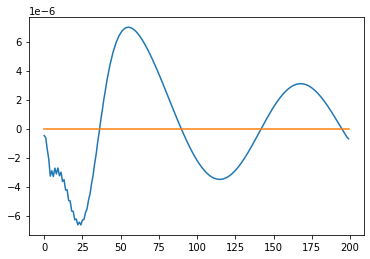

In [27]:
plt.plot([s.grad[0].item() for s in stims])
plt.plot([0.0 for s in stims])

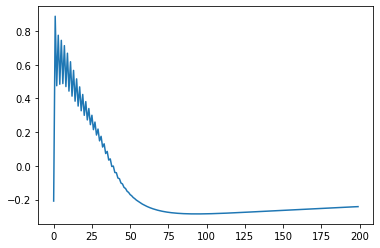

In [26]:
plt.plot([s[0].item() for s in stims])

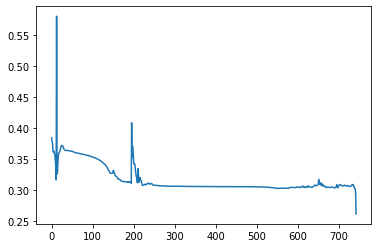

In [10]:
plt.plot(cpn_losses)

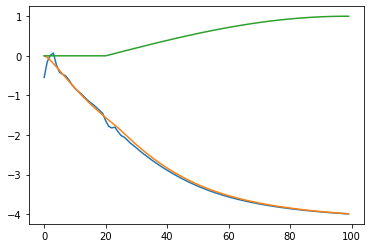

In [11]:
plt.plot(pred[0,:].detach().numpy())
plt.plot(all_obs[0,:].detach().numpy())
plt.plot(target[0,:,0].detach().numpy())
plt.show()


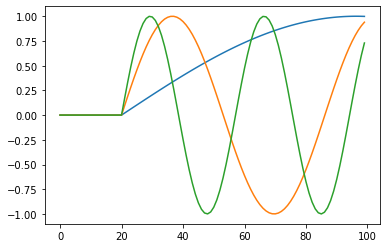

In [22]:
plt.plot(target[1,:,0].detach().numpy())
plt.plot(target[128,:,0].detach().numpy())

plt.plot(target[-1,:,0].detach().numpy())


nan
nan
2.5291595458984375


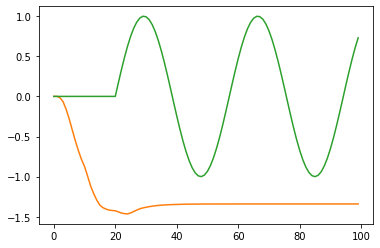

In [13]:
# Check fit of current ben and cpn
ben = recent_ben
cpn.reset()
ben.reset()

stims = []
pred = torch.zeros(batch_size, steps)
all_obs = torch.zeros(batch_size, steps)
noised = make_noised_cpn(cpn)
s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)
thing = [Thing(init=x.item()) for x in target[:, 0, 0].detach().numpy()]

#cpn_temp = CPNNoiseyPassthrough(cpn)
for tidx in range(steps):
    obs = [t.observe() for t in thing]
    new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
    all_obs[:, tidx:tidx+1] = new_obs
          
    ind = target[:, tidx, 1:3].reshape(256,2)
    cpn_in = torch.cat((new_obs, ind), axis=1)
    new_stim = cpn(cpn_in)

    ben_in = torch.cat((new_obs, new_stim, ind), axis=1)
    cur_pred = ben(ben_in)
    pred[:, tidx] = cur_pred.squeeze()
        
    s.add(new_stim)
    n = s.get_next().detach().numpy()

    obs = []
    for bidx in range(batch_size):
        thing[bidx].step(n[bidx, 0].item())


loss = torch.nn.MSELoss()
print(loss(pred, target[:, :, 0]).item())
print(loss(pred, all_obs).item())
print(loss(all_obs, target[:, :, 0]).item())

plt.plot(pred[-1, :].detach().numpy())
plt.plot(all_obs[-1, :].detach().numpy())
plt.plot(target[-1, :, 0].detach().numpy())

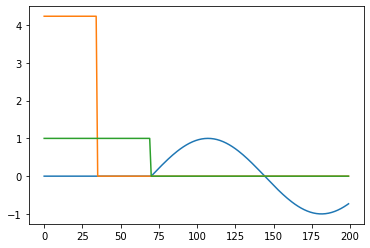

In [4]:
plt.plot(target[-1, :, 0].detach().numpy())
plt.plot(target[-1, :, 1].detach().numpy())
plt.plot(target[-1, :, 2].detach().numpy())